# 实验四 深度学习实验——基于人工神经网络的机器人地点识别

# 一、实验目的

1. 理解深度学习在图像分类任务中的基本原理和应用场景，尤其是针对机器人地点识别问题。
   
2. 掌握全连接神经网络的构建与使用，将其作为图像分类器，并与传统机器学习分类器（如朴素贝叶斯、KNN、决策树）进行对比分析。
   
3. 了解典型卷积神经网络进行特征提取的过程，并结合全连接神经网络实现图像分类，体会深度学习技术在特征提取和分类方面的优势。
   
4. 通过代码实现，熟悉深度神经网络的构建、训练、测试及部署流程，积累实际编程经验。

# 二、实验数据

采用与实验三相同的室内场景数据集，包含 6 个不同场景的图片数据，数据集已分为训练集和测试集，以便进行模型训练和测试。数据集的目录结构如下：

```plaintext
dataset
├── train
dataset/
├── 类别1/
│   ├── 图片1.jpg
│   ├── 图片2.jpg
│   └── ...
├── 类别2/
│   ├── 图片1.jpg
│   ├── 图片2.jpg
│   └── ...
└── ...

每个场景类别对应一个独立的文件夹，文件夹内包含该场景下的图片样本。文件夹名称即为类别标签，每个类别文件夹下存在的图片样本支持格式为.jpg、.png、.jpeg等。

训练集和测试集的划分比例为 8:2，即训练集包含 2437 张图片样本，测试集包含 616 张图片样本。划分结果保存在两个文件中，分别为train.txt和test.txt。

根据train.txt和test.txt文件中的路径信息，可以加载图片数据并进行后续的处理和分析。具体代码如下：

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

d:\ProgramData\Miniconda3\envs\torch_env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置随机种子，保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from imageDataset import ImageDataset

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 缩放图像为128x128
    transforms.ToTensor(),         # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 创建数据集
train_dataset = ImageDataset(
    txt_file='train.txt',
    root_dir='dataset',
    transform=transform
)

test_dataset = ImageDataset(
    txt_file='test.txt',
    root_dir='dataset',
    transform=transform
)

在上面的代码中，从train.txt和test.txt中读取了训练集和测试集的图片路径和标签后，使用ImageDataset类来进行图像样本的读入，同时对读入的图像进行缩放，缩放为统一的尺寸为128×128。

# 三、实验步骤

## 1. 全连接神经网络分类器

### 特征提取与分类器设计

加载了训练数据集和测试数据集以后，首先需要对图像进行预处理，以及必要的数据增强操作。而在当前步骤中，为了方便与前一次实验的结果进行对比，依然省略的图像预处理和数据增强的操作，只是简单的将图像按照先行后列的方式展开为特征向量。如下图所示。

![将图像展开为向量](将图像展开为向量.png)



接下来，使用全连接神经网络构造一个分类器。该分类器包含有两个隐层，一个输出层，隐层神经元的数量可以通过参数hidden_size来设定，而且第二个隐层的神经元数量为第一个隐层神经元数量的一半，输出层神经元的数量为第二个隐层神经元数量的一半。两个隐层的激活函数均为ReLU函数，并且设定隐层神经元随机失活的概率为0.5。

In [4]:
# 定义神经网络模型
class ImageClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ImageClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 添加dropout防止过拟合
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

为了更清楚的将全连接神经网络的结构展示出来，对超参数的具体数值进行制定。其中，隐层神经元的数量指定为512，那么按照前面的网络结构定义，第一层隐层有512个神经元，第二层隐层有256个神经元，输出层8个神经元。这里输出层神经元的数量与类别标签的数量一致。

In [5]:
# 设置参数
batch_size = 32
num_epochs = 20
learning_rate = 0.001
hidden_size = 512

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 获取类别数量
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")

# 计算输入大小 (3通道 * 128 * 128)
input_size = 3 * 128 * 128

# 创建模型
model = ImageClassifier(input_size, hidden_size, num_classes).to(device)
print(model)

Number of classes: 6
Classes: ['gym', 'museum', 'office', 'restaurant', 'subway', 'warehouse']
ImageClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)


在上面的代码中，构造的整体网络结构可以表示为下图：

<img src="全连接神经网络分类器结构.png" alt="全连接神经网络分类器的结构" width="500" height="300">

### 模型训练

全连接神经网络的训练采用梯度下降算法，寻找损失函数的最小值。由于处理的是图像分类任务，因此损失函数一般采用交叉熵损失(Cross Entropy Loss)。而小批量梯度下降算法为了避免陷入局部极小值，加快算法收敛速度，也有不同的改进算法，包括了动量法(Momentum)，自适应梯度法(如RMSProp，AdaGrad等)，以及Adam算法。目前，初级神经网络炼丹师都会采用Adam算法，因为它是动量法与自适应梯度法的结合，收敛速度快，效果也不错。

在模型训练过程中，由于采用的是小批量梯度下降算法，因此需要指定批量(Batch Size)的大小，以及梯度下降算法的学习率(Learning Rate)。这两个超参数，已经在之前的代码中指定过了。


In [6]:
from trainAndEvaluateModel import train_model, evaluate_model

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
print("\nTraining model...")
train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, device, num_epochs)


Training model...
Epoch 1/20, Loss: 6.7680, Accuracy: 0.2685
Epoch 2/20, Loss: 2.2272, Accuracy: 0.3145
Epoch 3/20, Loss: 1.7488, Accuracy: 0.3327
Epoch 4/20, Loss: 1.6470, Accuracy: 0.3291
Epoch 5/20, Loss: 1.5860, Accuracy: 0.3697
Epoch 6/20, Loss: 1.6038, Accuracy: 0.3388
Epoch 7/20, Loss: 1.5761, Accuracy: 0.3764
Epoch 8/20, Loss: 1.5600, Accuracy: 0.3770
Epoch 9/20, Loss: 1.4994, Accuracy: 0.4006
Epoch 10/20, Loss: 1.4829, Accuracy: 0.4061
Epoch 11/20, Loss: 1.4556, Accuracy: 0.4145
Epoch 12/20, Loss: 1.4665, Accuracy: 0.4339
Epoch 13/20, Loss: 1.4507, Accuracy: 0.4170
Epoch 14/20, Loss: 1.3989, Accuracy: 0.4327
Epoch 15/20, Loss: 1.4378, Accuracy: 0.4448
Epoch 16/20, Loss: 1.3964, Accuracy: 0.4673
Epoch 17/20, Loss: 1.3306, Accuracy: 0.4782
Epoch 18/20, Loss: 1.3275, Accuracy: 0.4842
Epoch 19/20, Loss: 1.3090, Accuracy: 0.5000
Epoch 20/20, Loss: 1.2730, Accuracy: 0.5103


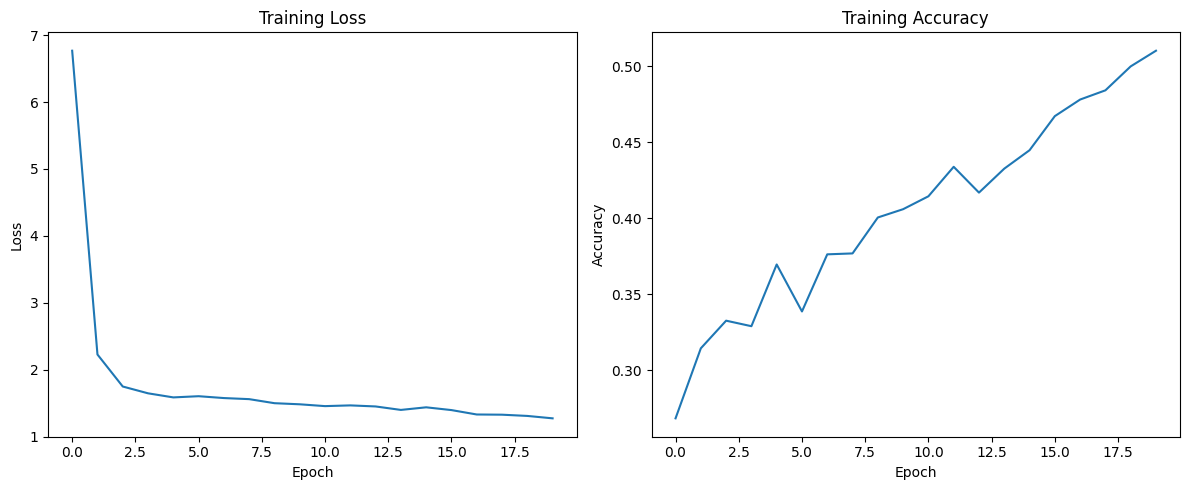

In [7]:
from plotFigures import plot_training_process, plot_confusion_matrix

# 绘制训练过程
plot_training_process(train_losses, train_accs)

### 模型评估

实验在测试集上进行模型的评估，并制作混淆矩阵，打印测试报告。

In [8]:
# 评估模型
print("\nEvaluating model...")
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)


Evaluating model...
Test Loss: 1.5552, Test Accuracy: 0.3846


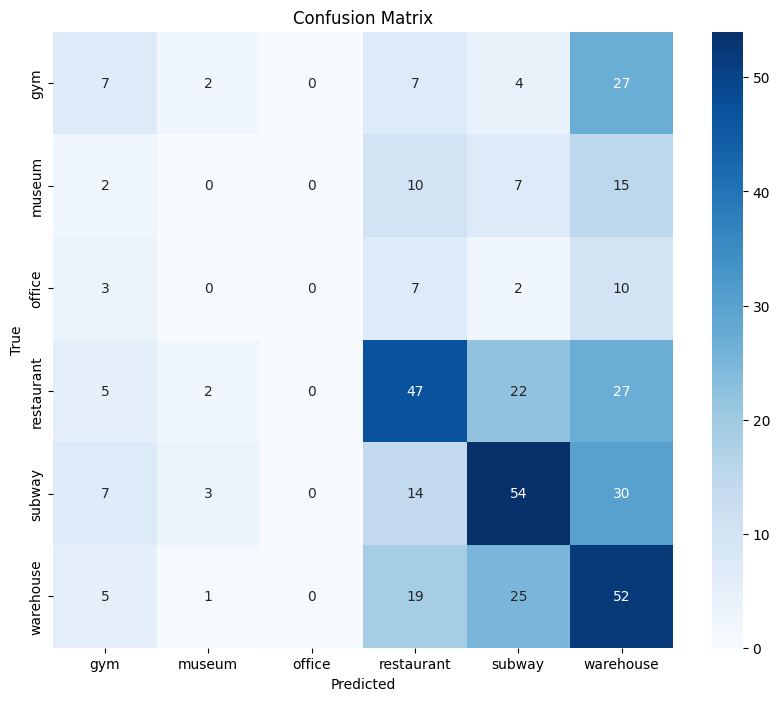

In [9]:
# 绘制混淆矩阵
plot_confusion_matrix(all_labels, all_preds, train_dataset.classes)

In [10]:
# 打印分类报告
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

         gym       0.24      0.15      0.18        47
      museum       0.00      0.00      0.00        34
      office       0.00      0.00      0.00        22
  restaurant       0.45      0.46      0.45       103
      subway       0.47      0.50      0.49       108
   warehouse       0.32      0.51      0.40       102

    accuracy                           0.38       416
   macro avg       0.25      0.27      0.25       416
weighted avg       0.34      0.38      0.36       416



d:\ProgramData\Miniconda3\envs\torch_env2\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ProgramData\Miniconda3\envs\torch_env2\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ProgramData\Miniconda3\envs\torch_env2\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**实验思考**

将这里得到的实验结果与实验三中没有使用SIFT算法得到的实验结果进行对比，看看哪种分类器的性能更强，为什么，从什么指标看出来的？

(双击此处写出你的答案)

### 模型部署

如果你对这个模型的分类性能还满意，那么可以将模型保存为.path文件，然后在其它需要使用模型的地方首先定义好模型的结构，然后使用torch.load()函数将模型参数加载进来，就可以直接使用模型进行推理预测了。

In [11]:
# 保存模型
#torch.save(model.state_dict(), 'image_classifier_model.pth')
#print("Model saved as 'image_classifier_model.pth'")

## 2. 卷积神经网络

失败是成功的老娘。道路坎坷，应该远胜于一帆风顺，所以卧薪尝胆，才能有后来的百二秦关终归楚。而又或者是因为秦关归楚得过于轻易，所以霸王殒命在大江之畔。说到底，成功也好，失败也好，保持一个时刻冷静的头脑，胜不骄，败不馁，这才是最重要的。我们的故事写到这里已经将要终章，然后自上次实验以来，似乎没有什么实验结果是可以让我们满意的，百分制三四十的分类准确率，如果应用于实际的机器人地点识别，与猜闷儿，几无区别，这也是为什么一直没有使用CoppeliaSim去对机器人地点识别进行仿真的原因。那么问题到底出在哪里呢？

回顾图像分类的全过程：首先是数据集准备，实验中使用的是一个经过阉割以后的数据集，因为百度AI Studio上传不了500M以上的文件，因此就到有些类别的数据样本数量非常少，看看前面的混淆矩阵，分得最差的三个类别健身房、博物馆、办公室，恰恰是图像样本最少的三个类别，这就为分类性能的提高制造了天然的障碍。

其次是数据预处理。如果数据集中图像样本的数量少，那么就应该在这一步想办法变出更多的图像样本来，那么有什么办法可以“变”出更多的图像样本呢？答案是数据增强。数据增强是指在不改变图像内容的前提下，通过对图像进行一系列的变换，来生成新的图像样本，从而增加数据集的规模。这一些列图像增强措施包括旋转、缩放、平移、裁剪、翻转、色彩变换、噪声添加等等。然而，在之前的实验中，我们是否采用了图像增强的办法？没有！

再次是特征提取。直接将图像按照先行后列的方式展开成特征向量，实在是太没有技术含量了，而且效果也不好。对比一下实验三中两次使用朴素贝叶斯分类器的经历，不难发现，使用SIFT算法进行图像特征提取以后，再进行分类，分类性能可以提升很多。这说明什么呢？说明任何努力不会白费的，都会是我们距离成功更近一点。

最后是分类器的选择，KNN，决策树，朴素贝叶斯，全连接神经网络，这是我们已经尝试过的几种分类器，孰优孰劣，认真做过实验的同学肯定都知道。如果没有认真做实验呢？看看他们出现的年代顺序，也能够大致猜出个一二来。

好了，问题分析得差不多了，既然故事行将结束，那么我们就一起设计一个圆满的结局吧。


#### 数据增强

为了实验结果对比的公平，还是使用之前一直在使用的数据集。然而，如前所述，这个数据集有天然的问题，阻碍了分类性能的提升。既然数据集本身不能做修改，那么我们就退而求其次，从数据预处理的角度着手，通过数据增强的方式，使图像样本尽可能丰富，于是我们就要开始施展魔法了！


In [12]:
# 设置参数
batch_size = 32
num_epochs = 20
learning_rate = 0.001

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 定义训练数据变换（包含数据增强）
train_transform = transforms.Compose([
    transforms.Resize((144, 144)),  # 稍大一些的尺寸，便于随机裁剪
    transforms.RandomCrop(128),    # 随机裁剪
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 颜色抖动
    transforms.ToTensor(),         # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

Using device: cuda


看看上面的代码，就会发现所谓数据增强，其手段也就是随机剪裁、随机水平翻转、随机旋转、颜色抖动而已，这些措施真的能够提升分类性能吗？让我们拭目以待。

需要注意的是，数据增强的方法只是针对训练集的，而验证集和测试集则不需要进行数据增强。

In [13]:
# 定义测试数据变换（不包含数据增强）
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 缩放图像为128x128
    transforms.ToTensor(),         # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 创建数据集
train_dataset = ImageDataset(
    txt_file='train.txt',
    root_dir='dataset',
    transform=train_transform  # 使用带数据增强的变换
)

test_dataset = ImageDataset(
    txt_file='test.txt',
    root_dir='dataset',
    transform=test_transform  # 使用不带数据增强的变换
)

#### 特征提取与分类器设计

特征提取是对图像所蕴含信息的再挖掘，之前通过使用SIFT图像特征提取方法，确实是使朴素贝叶斯算法的分类性能得到了提升。但是，SIFT特征提取算法毕竟是一种人工设计的特征提取方法，而卷积神经网络的出现，使得的特征的自动提取成为了可能。这里，不是说人工设计的特征提取方法就一定不好，只是人的认知总是存在一定局限性的，而当我们用自己的经验去设计图像特征提取器时，这个特征提取器的工作场景也就必然会存在一定的局限性。

经典的卷积神经网络都有哪些呢？AlexNet， VGGNet， GoogLeNet， ResNet等。ResNet，还记得2015年的ImageNet竞赛吗？Top5错误率第一次低于人类的，就是这个ResNet。正是遥想公瑾当年，羽扇纶巾，谈笑间，樯橹灰飞烟灭。那么，急用这个ResNet来提取图像特征吧。

由于这个网络模型太经典了，所以根本就不用自己搭建，直接导入一个34层的ResNet就可以。除了34层，ResNet还有110层，152层，182层等，如下图所示，网络模型的层数越多，其提取的特征就越丰富，但是相应的，其训练的时间就越长。

<img src="resnet表格.png" alt="resnet的结构" width="500" height="300">

分类器，仍然采用全连接神经网络分类器，因为如果没猜错的话，这个分类器是目前我们遇到的性能最好的分类器了。其结构仍然是两个隐层和一个输出层构成，两个隐层神经元的个数依次为512和256，输出层神经元的个数与类别标签的个数一致。因此，需要对ResNet模型的输出层做出一些改动，使的ResNet的输出可以接入全连接神经网络分类器。这样我们网络的整体结构就可以画成：

<img src="整体网络结构.png" alt="整体网络结构" width="500" height="300">



In [14]:
# 定义基于ResNet的神经网络模型
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNetClassifier, self).__init__()
        # 加载预训练的ResNet模型作为特征提取器
        # 使用ResNet-34
        self.feature_extractor = models.resnet34(pretrained=pretrained)
        
        # 获取ResNet最后一层的输出特征数
        feature_size = self.feature_extractor.fc.in_features
        
        # 移除ResNet的全连接层
        self.feature_extractor.fc = nn.Identity()
        
        # 添加自定义的三层全连接网络
        self.classifier = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # 使用ResNet提取特征
        features = self.feature_extractor(x)
        # 通过全连接层进行分类
        return self.classifier(features)

In [15]:
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 获取类别数量
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")

# 创建基于ResNet的模型
model = ResNetClassifier(num_classes=num_classes, pretrained=True).to(device)
print(model)

Number of classes: 6
Classes: ['gym', 'museum', 'office', 'restaurant', 'subway', 'warehouse']


d:\ProgramData\Miniconda3\envs\torch_env2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\Miniconda3\envs\torch_env2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetClassifier(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

#### 模型训练

模型训练依然采用梯度下降算法，使用交叉熵作为损失函数，作为初级炼丹师，直接使用adam实现小批量梯度下降。


Training model...
Epoch 1/20, Loss: 1.2976, Accuracy: 0.5376
Epoch 2/20, Loss: 1.0548, Accuracy: 0.6273
Epoch 3/20, Loss: 0.9282, Accuracy: 0.6806
Epoch 4/20, Loss: 0.9411, Accuracy: 0.6836
Epoch 5/20, Loss: 0.8192, Accuracy: 0.7218
Epoch 6/20, Loss: 0.7993, Accuracy: 0.7364
Epoch 7/20, Loss: 0.7627, Accuracy: 0.7436
Epoch 8/20, Loss: 0.7346, Accuracy: 0.7636
Epoch 9/20, Loss: 0.6938, Accuracy: 0.7794
Epoch 10/20, Loss: 0.6611, Accuracy: 0.7745
Epoch 11/20, Loss: 0.6347, Accuracy: 0.7861
Epoch 12/20, Loss: 0.5860, Accuracy: 0.8079
Epoch 13/20, Loss: 0.5026, Accuracy: 0.8309
Epoch 14/20, Loss: 0.4925, Accuracy: 0.8358
Epoch 15/20, Loss: 0.5324, Accuracy: 0.8230
Epoch 16/20, Loss: 0.5193, Accuracy: 0.8345
Epoch 17/20, Loss: 0.4373, Accuracy: 0.8661
Epoch 18/20, Loss: 0.4325, Accuracy: 0.8636
Epoch 19/20, Loss: 0.4087, Accuracy: 0.8739
Epoch 20/20, Loss: 0.4319, Accuracy: 0.8636


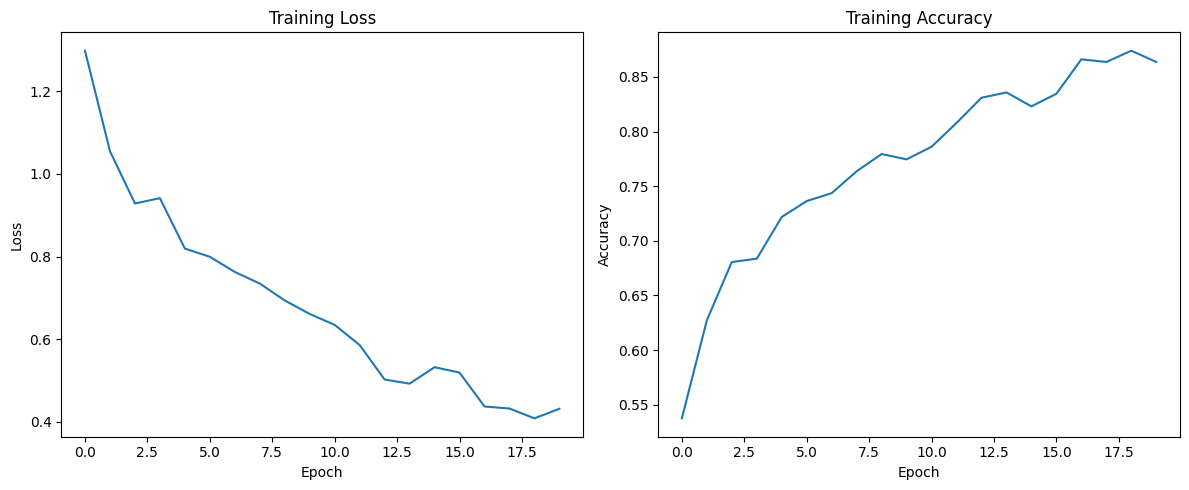

In [16]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
print("\nTraining model...")
train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, device, num_epochs)

# 绘制训练过程
plot_training_process(train_losses, train_accs)

#### 模型评估

在测试集上对训练好的模型进行评估，让我们再来看看混淆矩阵的主对角线是否会被彻底点亮。


Evaluating model...
Test Loss: 0.7828, Test Accuracy: 0.7668


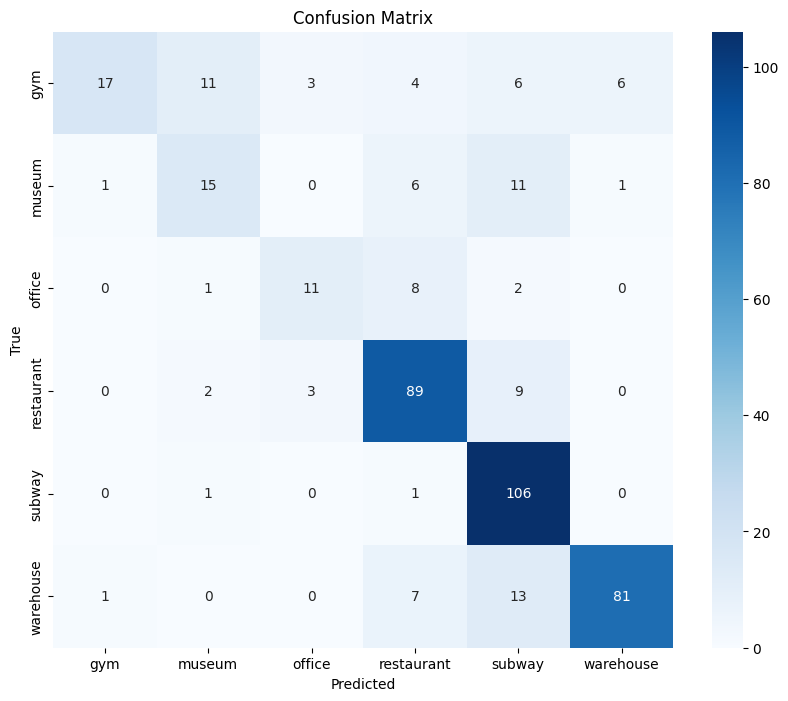

In [17]:
# 评估模型
print("\nEvaluating model...")
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

# 绘制混淆矩阵
plot_confusion_matrix(all_labels, all_preds, train_dataset.classes)

In [18]:
# 打印分类报告
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

         gym       0.89      0.36      0.52        47
      museum       0.50      0.44      0.47        34
      office       0.65      0.50      0.56        22
  restaurant       0.77      0.86      0.82       103
      subway       0.72      0.98      0.83       108
   warehouse       0.92      0.79      0.85       102

    accuracy                           0.77       416
   macro avg       0.74      0.66      0.67       416
weighted avg       0.78      0.77      0.75       416



#### 模型部署

这个模型你满意吗？如果满意，那么把模型给参数保存下来，需要使用的时候，只需要定义好模型结构，然后加载训练好的模型参数就可以预测推理了。

In [19]:
# 保存模型
#torch.save(model.state_dict(), 'resnet_classifier_model.pth')
#print("Model saved as 'resnet_classifier_model.pth'")

如果你对这个模型还不是很满意，那么想一想还可以再做点什么来提升它的性能？

无论满意或是不满意，时间到了，故事就该结束了。可是故事真的结束了吗？也许故事才刚刚开始，还好，它开始于一个有所追求的地方，开始于追求更高识别性能的地方，开始于2025年的春天，开始于一间教室，在这间教室里，一位教师站在讲台上说：“让我们一起来学习一下这门课，这门课的名字是‘人工智能基础’……”